# PyTorch Transfer Learning

## 0. Getting Setup

In [ ]:
# Import require lib
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import data_setup
import engine

from torch import nn
from torchvision import datasets
from torchvision.transforms.v2 import Compose, Resize, ToImage, ToDtype, Normalize
from torchinfo import summary


## 1. Get Data

In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [7]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

 Since we can use the data_setup.py script for creating our datasets and dataloaders.

But since we'll be using a pretrained model from torchvision.models, there's a specific transform we need to prepare our images first.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [8]:
# Create a transforms pipeline manually 
manual_transforms = Compose([
    Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    ToImage(),
    ToDtype(dtype=torch.float32,scale=True),
    Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
             std=[0.229, 0.224, 0.225]), # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])
manual_transforms

Compose(
      Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [9]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x128643c70>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for torchvision.models (auto creation)

As previously stated, when using a pretrained model, it's important that ***your custom data going into the model is prepared in the same way as the original training data that went into the model***.

Above we saw how to manually create a transform for a pretrained model.

But as of torchvision v0.13+, an automatic transform creation feature has been added.

When you setup a model from torchvision.models and select the pretrained model weights you'd like to use, for example, say we'd like to use:

```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```
See more details here - https://docs.pytorch.org/vision/stable/models.html
https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html?highlight=efficientnet_b0_weights#torchvision.models.EfficientNet_B0_Weights

In [10]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Notice how `auto_transforms` is very similar to `manual_transforms`, the only difference is that `auto_transforms` came with the model architecture we chose, where as we had to create `manual_transforms` by hand.

The benefit of automatically creating a transform through `weights.transforms()` is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

However, the tradeoff of using automatically created transforms is a lack of customization.

We can use `auto_transforms` to create DataLoaders with `create_dataloaders()` just as before.

In [12]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x128676320>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

Our models haven't been performing as well as we'd like.That's where **transfer learning** comes in.
The whole idea of transfer learning is to **take an already well-performing model on a problem-space similar to yours and then customise it to your use case**.

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in `torchvision.models`.

Models are : 
1. ResNet - torchvision.models.resnet18(), torchvision.models.resnet50(),...
2. VGG (similar to what we used for TinyVGG) - torchvision.models.vgg16(), ...
3. EfficientNet - torchvision.models.efficientnet_b0(), torchvision.models.efficientnet_b1(), ...
4. VisionTransformer (ViT's) - torchvision.models.vit_b_16(), torchvision.models.vit_b_32()...
5. ConvNeXt - torchvision.models.convnext_tiny(), torchvision.models.convnext_small()...

More details : https://pytorch.org/vision/stable/models.html

### 3.1 Which pretrained model should you use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. `efficientnet_b0() -> efficientnet_b1() -> efficientnet_b7()`) means better performance but a larger model.

You might think better performance is always better, right?

That's true but **some better performing models are too big for some devices**.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, as [The Bitter Lesson states](http://www.incompleteideas.net/IncIdeas/BitterLesson.html), you'd likely take the biggest, most compute hungry model you can.

Understanding this **performance vs. speed vs. size tradeoff** will come with time and practice.

### 3.2 Setting up a pretrained model
The pretrained model we're going to be using is `torchvision.models.efficientnet_b0()`. - https://research.google/blog/efficientnet-improving-accuracy-and-efficiency-through-automl-and-model-scaling/

In [13]:
# Setup the model with pretrained weights 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 

# Setup the model with pretrained weights and send it to device 
#model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# in my case i will use cpu
model = torchvision.models.efficientnet_b0(weights=weights)

model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/aungsan/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:07<00:00, 2.71MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [15]:
# Print a summary using torchinfo
summary(model=model, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the features section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

Our problem is classifying 3 different food items but the pretrained model we're using was trained on 1000 different classes of images.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

In [19]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
  )

  And we'll keep in_features=1280 for our `Linear` output layer but we'll change the out_features value to the length of our `class_names (len(['pizza', 'steak', 'sushi']) = 3)`.

In [21]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True))

In [22]:
# View the summary after freezing
summary(model, 
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model

In [23]:
# Create loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [25]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device="cuda" if torch.cuda.is_available() else "cpu")

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/aungsan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.0883 | train_acc: 0.4180 | test_loss: 0.8914 | test_acc: 0.6818
Epoch: 2 | train_loss: 0.9162 | train_acc: 0.6289 | test_loss: 0.8027 | test_acc: 0.7443
Epoch: 3 | train_loss: 0.8162 | train_acc: 0.7031 | test_loss: 0.6787 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7460 | train_acc: 0.7305 | test_loss: 0.6744 | test_acc: 0.8040
Epoch: 5 | train_loss: 0.6209 | train_acc: 0.7695 | test_loss: 0.6263 | test_acc: 0.8561
[INFO] Total training time: 399.107 seconds


## 5. Evaluate model by plotting loss curves

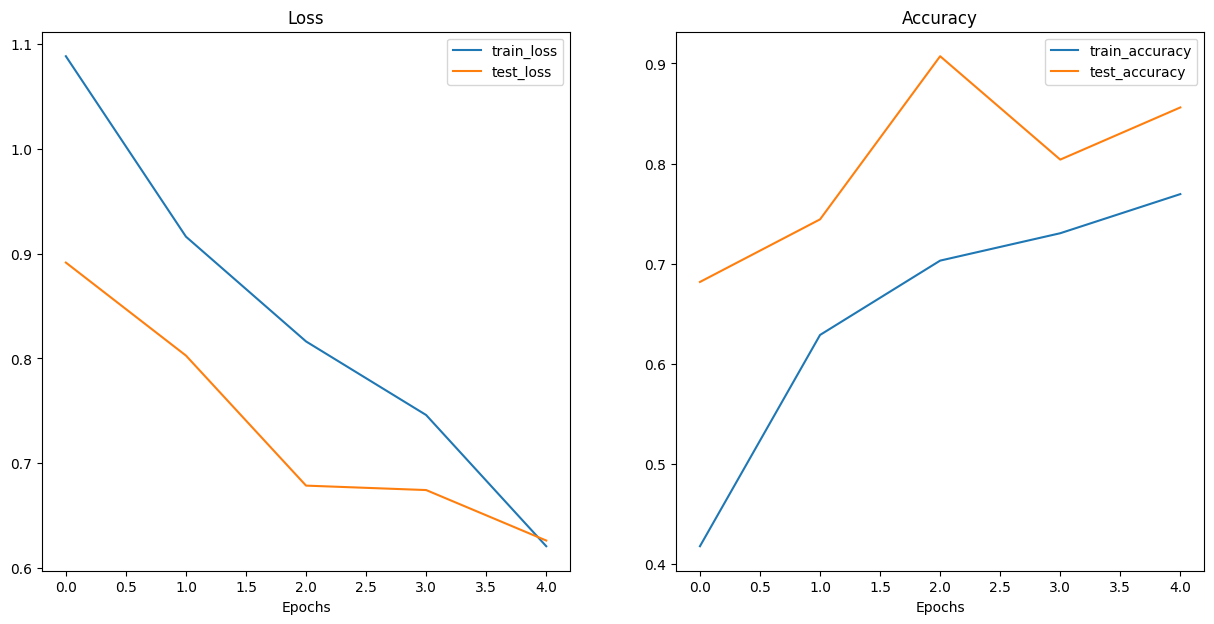

In [26]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

It looks like the loss for both datasets (train and test) is heading in the right direction its mean (right fit)

The same with the accuracy values, trending upwards.

That goes to show the power of transfer learning. Using a pretrained model often leads to pretty good results with a small amount of data in less time.

## 6. Make predictions on images from the test set

In [28]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=None):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = Compose([
            Resize(image_size),
            ToImage(),
            ToDtype(torch.float, scale=True),
            Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 
    # 4. Make sure the model is on the target device
    #model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);


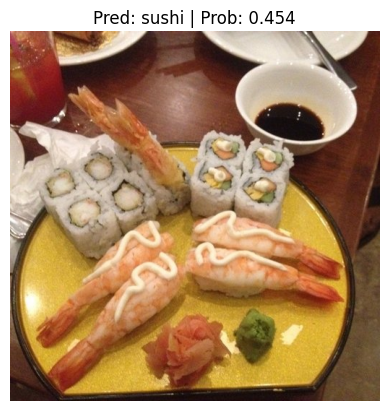

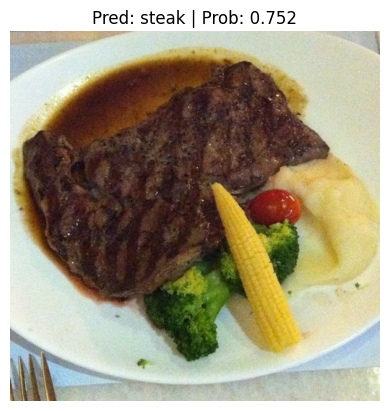

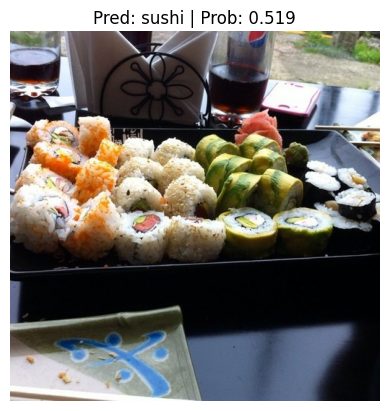

In [30]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

## 6.1 Making predictions on a custom image

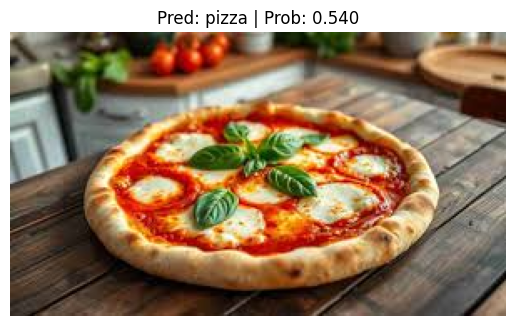

In [31]:
# Setup custom image path

custom_data_path = Path("images/")
custom_image_path = custom_data_path / "pizza.jpeg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)